Writer: Yinbo Song
Email: songyinbo@outlook.com
Date: 2023.07.03

In [1]:
%reset -f
import numpy as np
import pandas as pd
%clear

# 1 Import the results of photogrammetry， including the sparse point clouds before and after deformation
points = pd.read_excel('data\zxt_300Pa.xlsx', sheet_name = 'points')
points_deformed = pd.read_excel('data\zxt_9000Pa.xlsx', sheet_name = 'points')

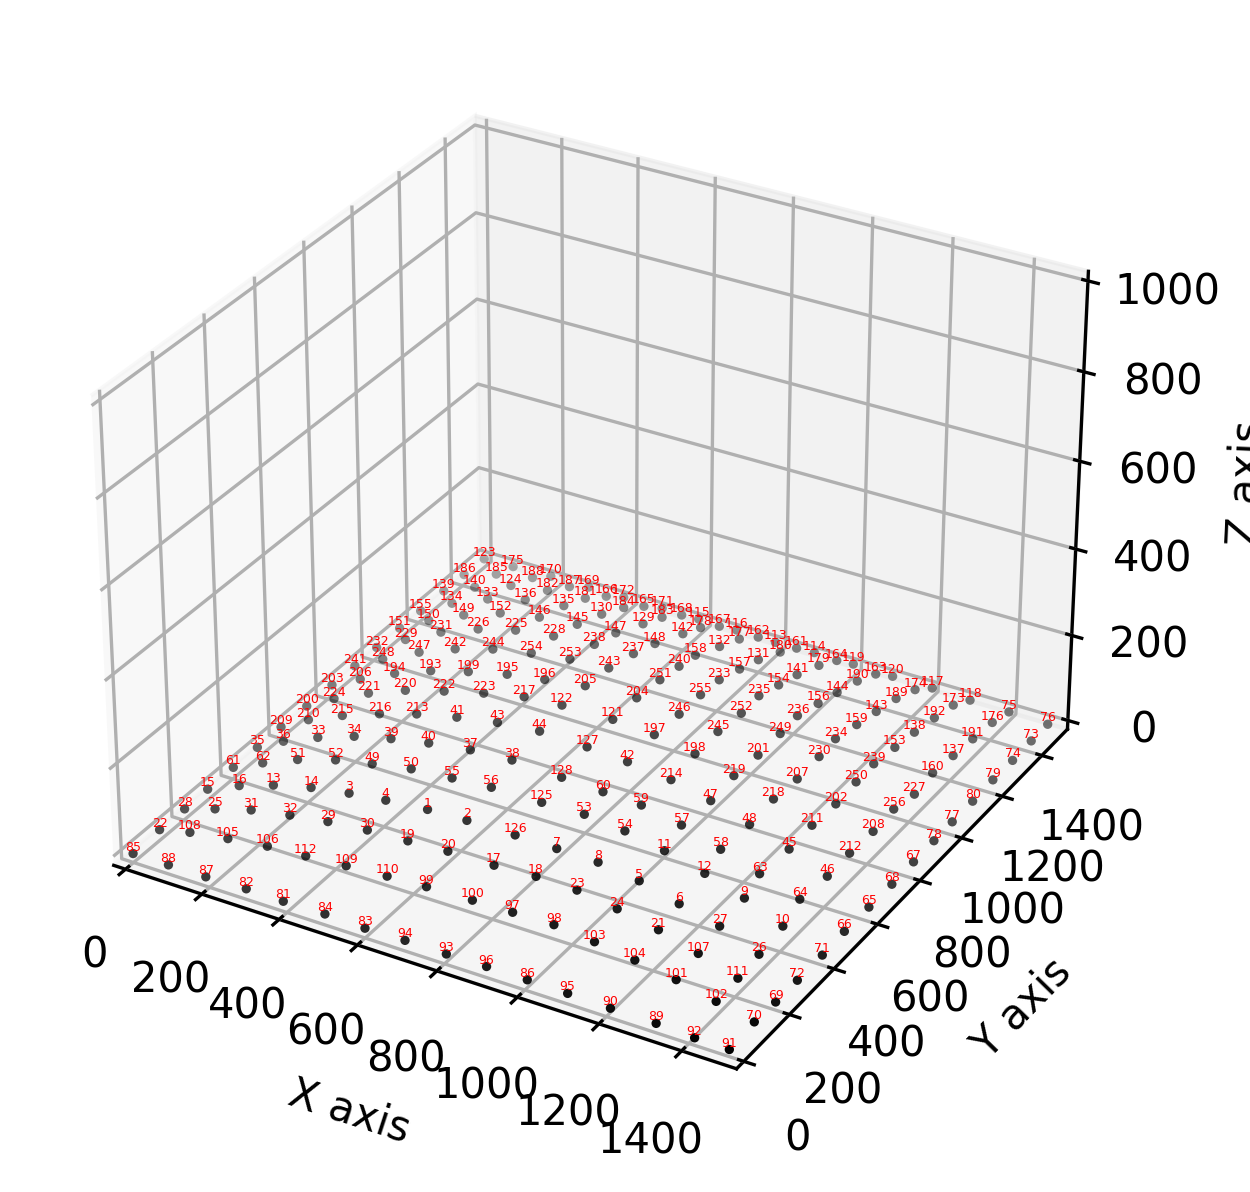

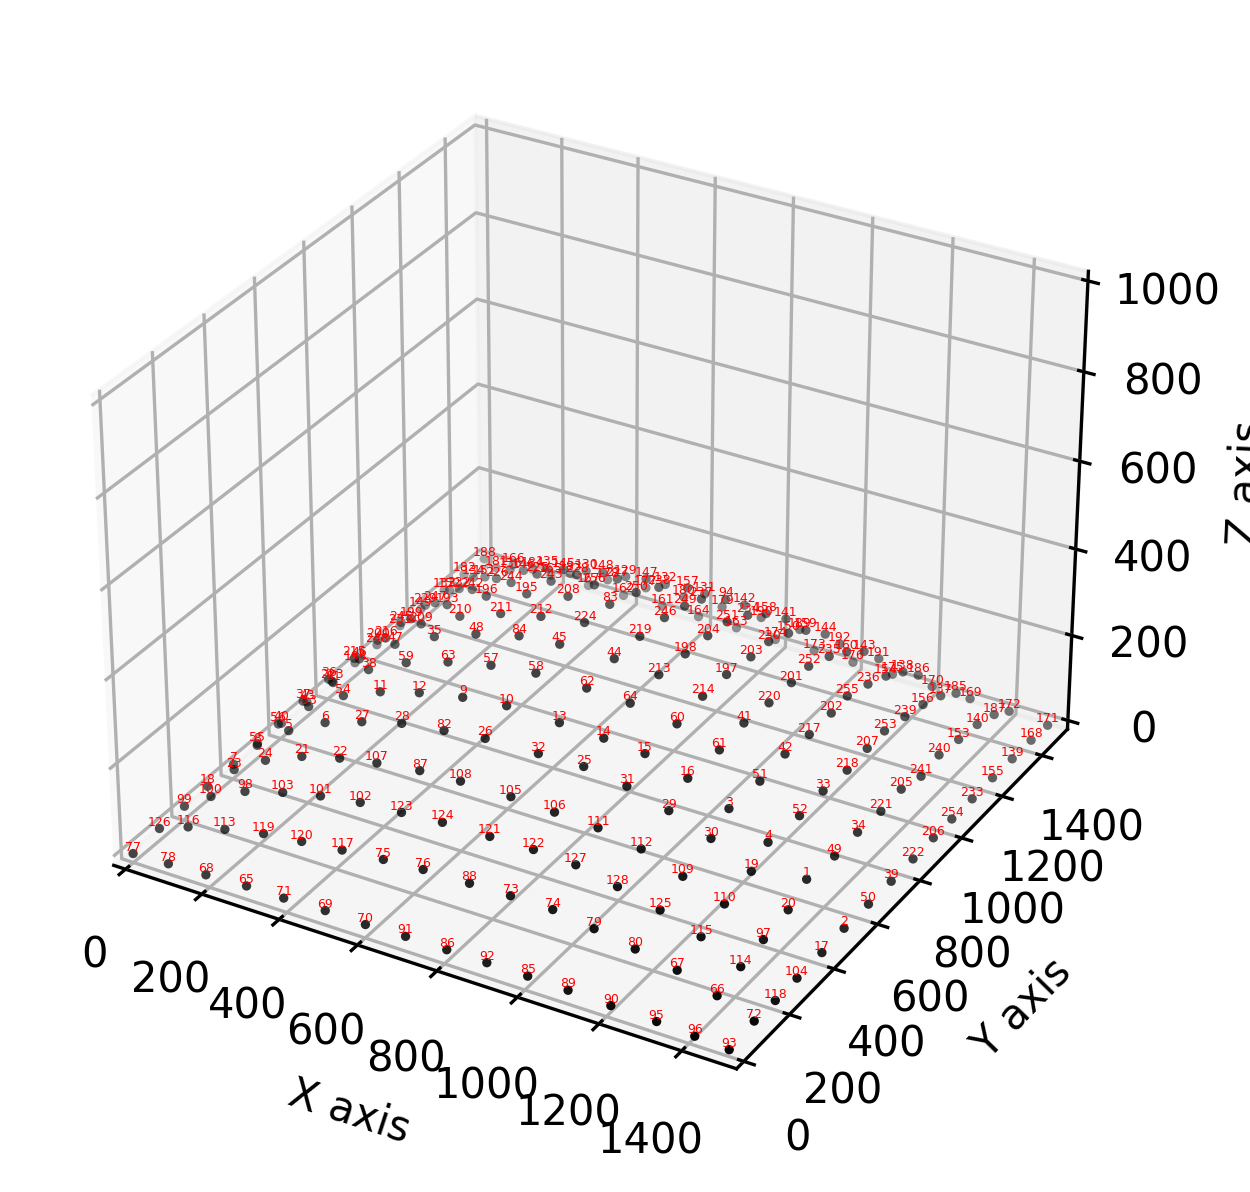

In [2]:
# 1.1 Check the sparse point cloud before deformation
from matplotlib import pyplot as plt
plt.close("all")
from mpl_toolkits.mplot3d import axes3d
plt.figure(dpi=300)
ax = plt.axes(projection = '3d')
ax.set_xlim(0, 1500)
ax.set_ylim(0, 1500)
ax.set_zlim(0, 1000)
ax.scatter(points['point_x'], points['point_y'], points['point_z'], s = 5,
    color = 'k', 
    marker = 'o',
    linewidths=0)
ax.set_xlabel('X axis') 
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
for i in range(points.shape[0]):
    ax.text(points['point_x'][i], points['point_y'][i], points['point_z'][i],
            points['point_ID'][i],
            fontsize = 3,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

# 1.2 Check the sparse point cloud after deformation
plt.figure(dpi=300)
ax = plt.axes(projection = '3d')
ax.set_xlim(0, 1500)
ax.set_ylim(0, 1500)
ax.set_zlim(0, 1000)
ax.scatter(points_deformed['point_x'], points_deformed['point_y'], points_deformed['point_z'], s = 5,
    color = 'k', 
    marker = 'o',
    linewidths=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
for i in range(len(points_deformed['point_ID'])):
    ax.text(points_deformed['point_x'][i], points_deformed['point_y'][i], points_deformed['point_z'][i],
            points_deformed['point_ID'][i],
            fontsize = 3,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')
del ax, i

The following code block requires the number of rows and columns of the target posted on the membrane surface:

In [3]:
# 2 Recode the point clouds
# 2.1 Recode the point cloud before deformation
points = points.sort_values(by='point_y')
group = []
points_new = pd.DataFrame()
num_rowx = 16 # Number of rows in x-direction
num_rowy = 16 # Number of rows in y-direction
for i in range(num_rowx):
        group.append(points.iloc[num_rowy * i : num_rowy * (i + 1), ])
        group[i] = group[i].sort_values(by='point_x')
        #points_new = points_new.append(group[i])
        points_new = pd.concat([points_new, group[i]], ignore_index=True)

points_new = points_new.reset_index(drop=True)
for i in range(len(points_new['point_ID'])):
        points_new.loc[i, 'point_ID'] = i
points = points_new
del points_new, group

# 2.2 Recode the point cloud after deformation
num_rowx = 16
num_rowy = 16
points_deformed = points_deformed.sort_values(by='point_y')
group = []
points_deformed_new = pd.DataFrame()
for i in range(num_rowx):
        group.append(points_deformed.iloc[num_rowy * i : num_rowy * (i + 1), ])
        group[i] = group[i].sort_values(by='point_x')
        #points_deformed_new = points_deformed_new.append(group[i])
        points_deformed_new = pd.concat([points_deformed_new, group[i]], ignore_index=True)
points_deformed_new = points_deformed_new.reset_index(drop=True)
for i in range(len(points_deformed_new['point_ID'])):
        points_deformed_new.loc[i, 'point_ID'] = i
points_deformed = points_deformed_new
del points_deformed_new, group, i, num_rowx, num_rowy

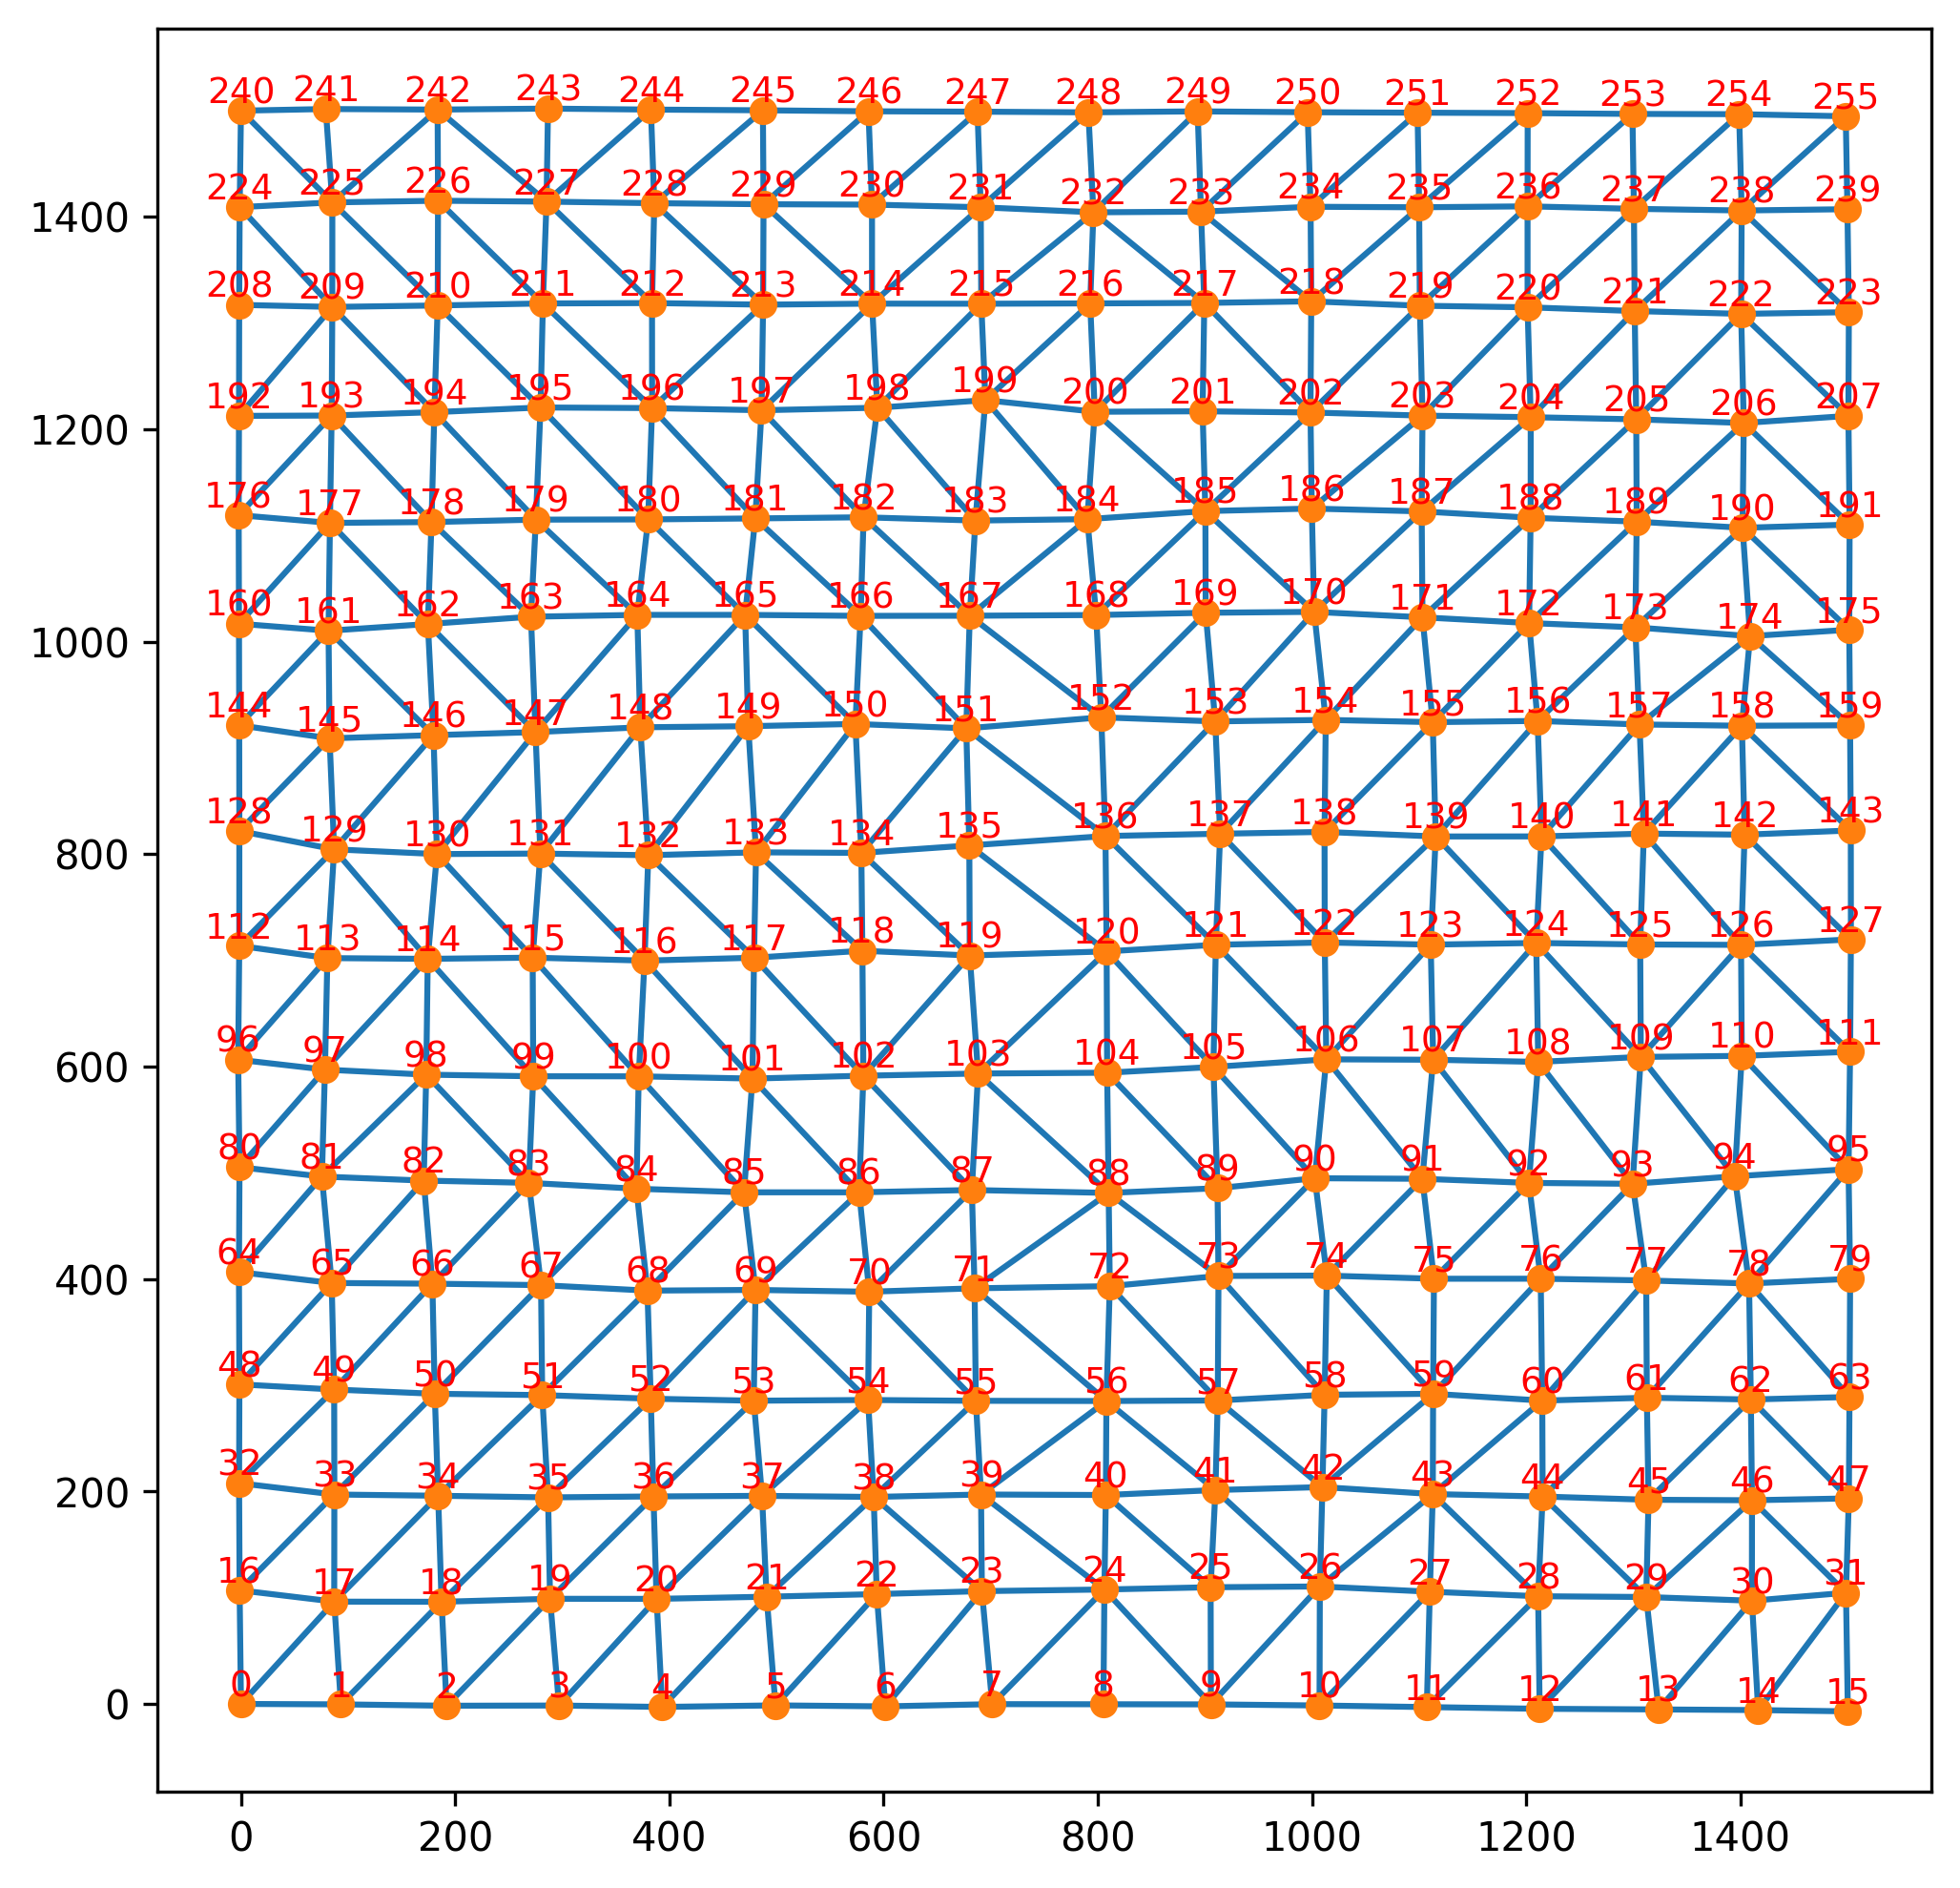

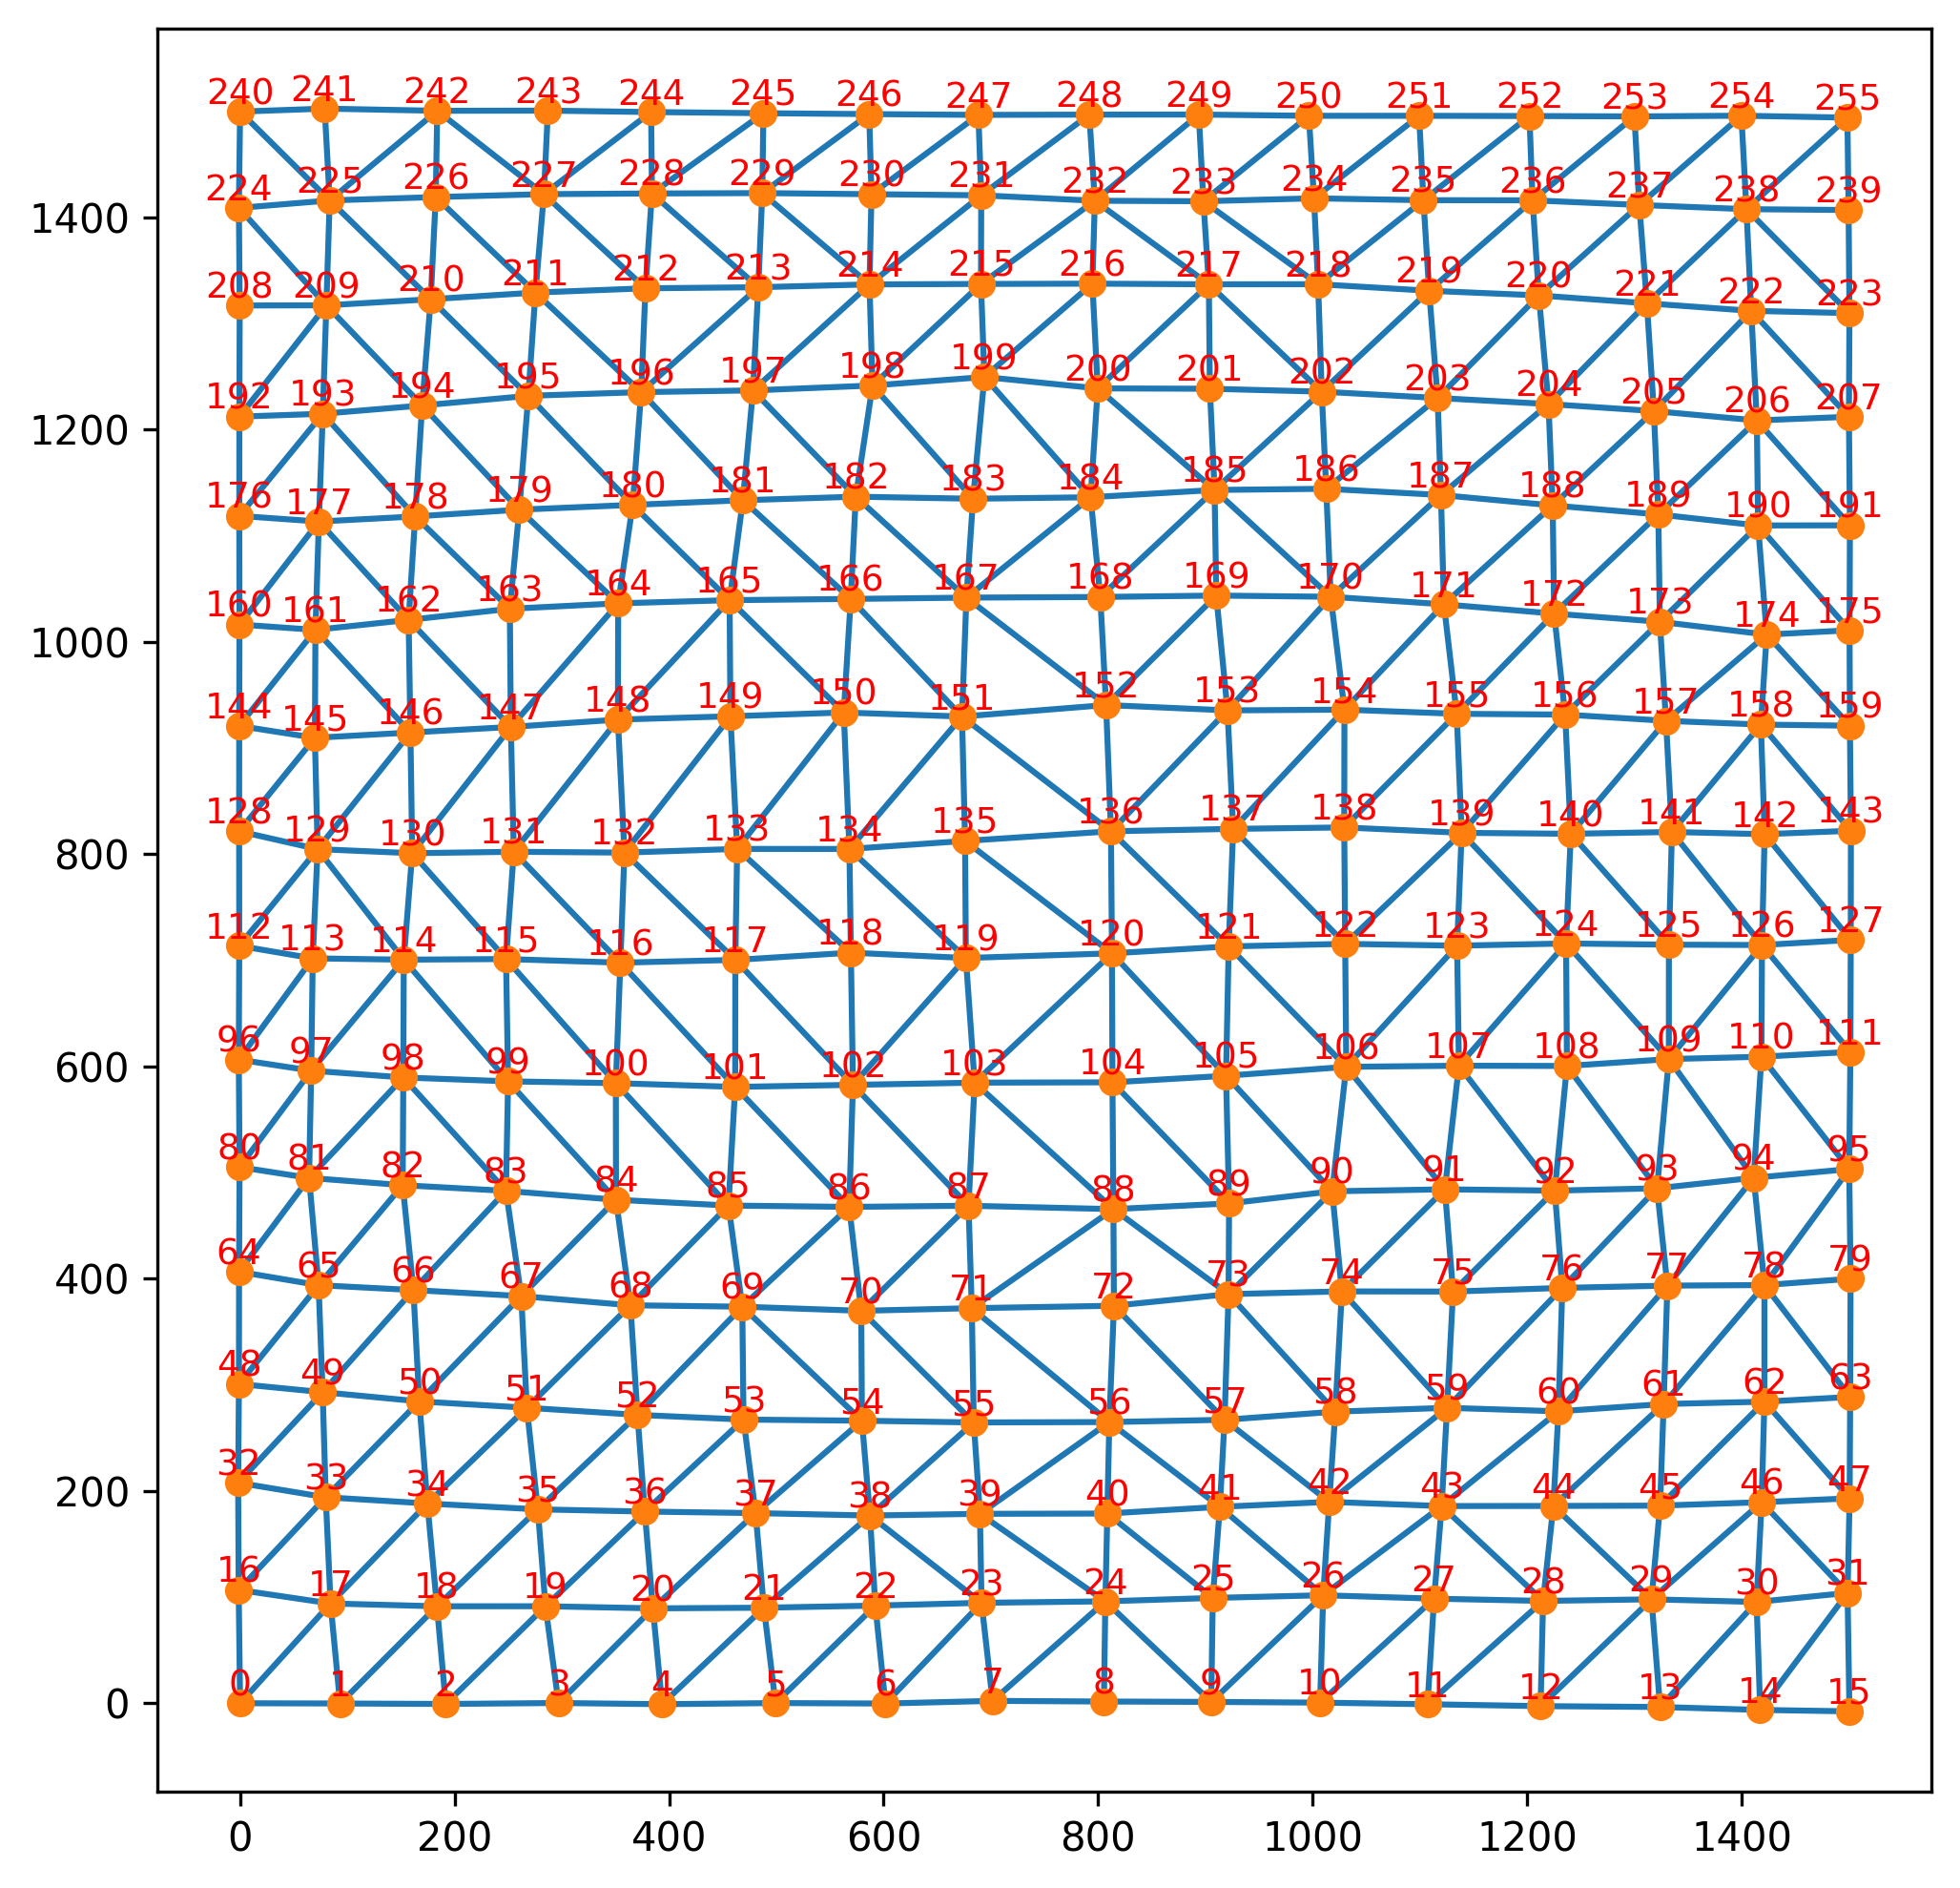

In [4]:
# 3 The point clouds is triangulated to obtain the relation between the element and the nodes
# 3.1 Triangulation of the point cloud before deformation
import matplotlib.tri as mtri
from matplotlib.tri import Triangulation, LinearTriInterpolator

xy = np.array(points.iloc[:, [1,2]])
triang = mtri.Triangulation(xy[:,0], xy[:,1])
element_nodes = triang.triangles

# Delete the narrow triangles near the boundary
import math
distance = 100
s = 1.3
node0 = element_nodes[:, 0]
node1 = element_nodes[:, 1]
node2 = element_nodes[:, 2]
I = []

for i in range(element_nodes.shape[0]):
    x0_x1 = abs(points['point_x'][node0[i]] - points['point_x'][node1[i]])
    y0_y1 = abs(points['point_y'][node0[i]] - points['point_y'][node1[i]])
    x1_x2 = abs(points['point_x'][node1[i]] - points['point_x'][node2[i]])
    y1_y2 = abs(points['point_y'][node1[i]] - points['point_y'][node2[i]])
    x0_x2 = abs(points['point_x'][node0[i]] - points['point_x'][node2[i]])
    y0_y2 = abs(points['point_y'][node0[i]] - points['point_y'][node2[i]])
    if x0_x1>distance*s or y0_y1>distance*s or x1_x2>distance*s or y1_y2>distance*s \
        or x0_x2>distance*s or y0_y2>distance*s :
        I.append(i)
    else:
        pass
element_nodes = np.delete(element_nodes, I, axis=0)
triang = mtri.Triangulation(xy[:,0], xy[:,1], element_nodes)

plt.figure(dpi=300, figsize=(8,8))
plt.triplot(triang, marker="o")

for i in range(xy.shape[0]):
    plt.text(xy[i][0], xy[i][1],
            points['point_ID'][i],
            fontsize = 9,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

# 3.2 Triangulation of the point cloud after deformation
node_deformed = points_deformed.iloc[:, [1,2]]
xy_deformed = np.array(node_deformed)
triang_deformed = mtri.Triangulation(xy_deformed[:,0], xy_deformed[:,1], element_nodes)

plt.figure(dpi=300, figsize=(8,8))
plt.triplot(triang_deformed, marker="o")

for i in range(xy_deformed.shape[0]):
    plt.text(xy_deformed[i][0], xy_deformed[i][1],
            points_deformed['point_ID'][i],
            fontsize = 9,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

In [5]:
# 4 Calculate the length of membrane links before and after deformation
node0 = element_nodes[:, 0]
node1 = element_nodes[:, 1]
node2 = element_nodes[:, 2]

line0 = [] # Storage of the length of the 0th membrane line of the undeformed triangular cell (a)
line1 = [] # Storage of the length of the 1st membrane line of the undeformed triangular cell (b)
line2 = [] # Storage of the length of the 2nd membrane line of undeformed triangular cells (c)

for i in range(element_nodes.shape[0]): # Calculation of membrane line lengths for undeformed triangular cells
    x0_x1 = abs(points['point_x'][node0[i]] - points['point_x'][node1[i]])
    y0_y1 = abs(points['point_y'][node0[i]] - points['point_y'][node1[i]])
    z0_z1 = abs(points['point_z'][node0[i]] - points['point_z'][node1[i]])
    line0.append(math.sqrt(x0_x1**2 + y0_y1**2 + z0_z1**2))

    x1_x2 = abs(points['point_x'][node1[i]] - points['point_x'][node2[i]])
    y1_y2 = abs(points['point_y'][node1[i]] - points['point_y'][node2[i]])
    z1_z2 = abs(points['point_z'][node1[i]] - points['point_z'][node2[i]])
    line1.append(math.sqrt(x1_x2**2 + y1_y2**2 + z1_z2**2))

    x0_x2 = abs(points['point_x'][node0[i]] - points['point_x'][node2[i]])
    y0_y2 = abs(points['point_y'][node0[i]] - points['point_y'][node2[i]])
    z0_z2 = abs(points['point_z'][node0[i]] - points['point_z'][node2[i]])
    line2.append(math.sqrt(x0_x2**2 + y0_y2**2 + z0_z2**2))

line0_deformed = [] # Storage of the length of the 0th membrane line of the deformed triangular cell (a')
line1_deformed = [] # Storage of the length of the 1st membrane line of the deformed triangular cell (b')
line2_deformed = [] # Storage of the length of the 2nd membrane line of the deformed triangular cell (c')
for i in range(element_nodes.shape[0]): # Calculate the length of the membrane line of the deformed triangular cell
    x0_x1 = abs(points_deformed['point_x'][node0[i]] - points_deformed['point_x'][node1[i]])
    y0_y1 = abs(points_deformed['point_y'][node0[i]] - points_deformed['point_y'][node1[i]])
    z0_z1 = abs(points_deformed['point_z'][node0[i]] - points_deformed['point_z'][node1[i]])
    line0_deformed.append(math.sqrt(x0_x1**2 + y0_y1**2 + z0_z1**2))

    x1_x2 = abs(points_deformed['point_x'][node1[i]] - points_deformed['point_x'][node2[i]])
    y1_y2 = abs(points_deformed['point_y'][node1[i]] - points_deformed['point_y'][node2[i]])
    z1_z2 = abs(points_deformed['point_z'][node1[i]] - points_deformed['point_z'][node2[i]])
    line1_deformed.append(math.sqrt(x1_x2**2 + y1_y2**2 + z1_z2**2))

    x0_x2 = abs(points_deformed['point_x'][node0[i]] - points_deformed['point_x'][node2[i]])
    y0_y2 = abs(points_deformed['point_y'][node0[i]] - points_deformed['point_y'][node2[i]])
    z0_z2 = abs(points_deformed['point_z'][node0[i]] - points_deformed['point_z'][node2[i]])
    line2_deformed.append(math.sqrt(x0_x2**2 + y0_y2**2 + z0_z2**2))

In [6]:
# 5 Calculate principal strain through the change of membrane link length
E11 = []
E22 = []
E12 = []
epsilon1 = []
epsilon2 = []
tao = []
a = line0
b = line1
c = line2
A = line0_deformed
B = line1_deformed
C = line2_deformed

for i in range(element_nodes.shape[0]):
     E11.append((A[i]**2 - a[i]**2)/(2*a[i]**2))
     E22.append(((A[i]**2 + a[i]**2) * (a[i]**2 + c[i]**2 - b[i]**2)**2 \
        + 4 * a[i]**4 * C[i]**2 - 2 * a[i]**2 * (A[i]**2 + C[i]**2 - B[i]**2)*\
        (a[i]**2 + c[i]**2 - b[i]**2) - 4 * a[i]**4 * c[i]**2)/(8 * a[i]**4 * c[i]**2\
         - 2 * a[i]**2 * (a[i]**2 + c[i]**2 - b[i]**2)**2))
     E12.append((A[i]**2 * (a[i]**2 + c[i]**2 - b[i]**2)**2 - a[i]**2\
         * (a[i]**2 + c[i]**2 - b[i]**2)*(A[i]**2 + C[i]**2 - B[i]**2))/(4 * a[i]**4 * c[i]**2))
    
     epsilon1.append(math.log(math.sqrt(1 + 2*(E11[i] + E22[i])/2 + math.sqrt(((E11[i] - E22[i])/2)**2 + E12[i]**2))))
     epsilon2.append(math.log(math.sqrt(1 + 2*(E11[i] + E22[i])/2 - math.sqrt(((E11[i] - E22[i])/2)**2 + E12[i]**2))))
     tao.append(math.sqrt(((E11[i] - E22[i])/2)**2 + E12[i]**2))


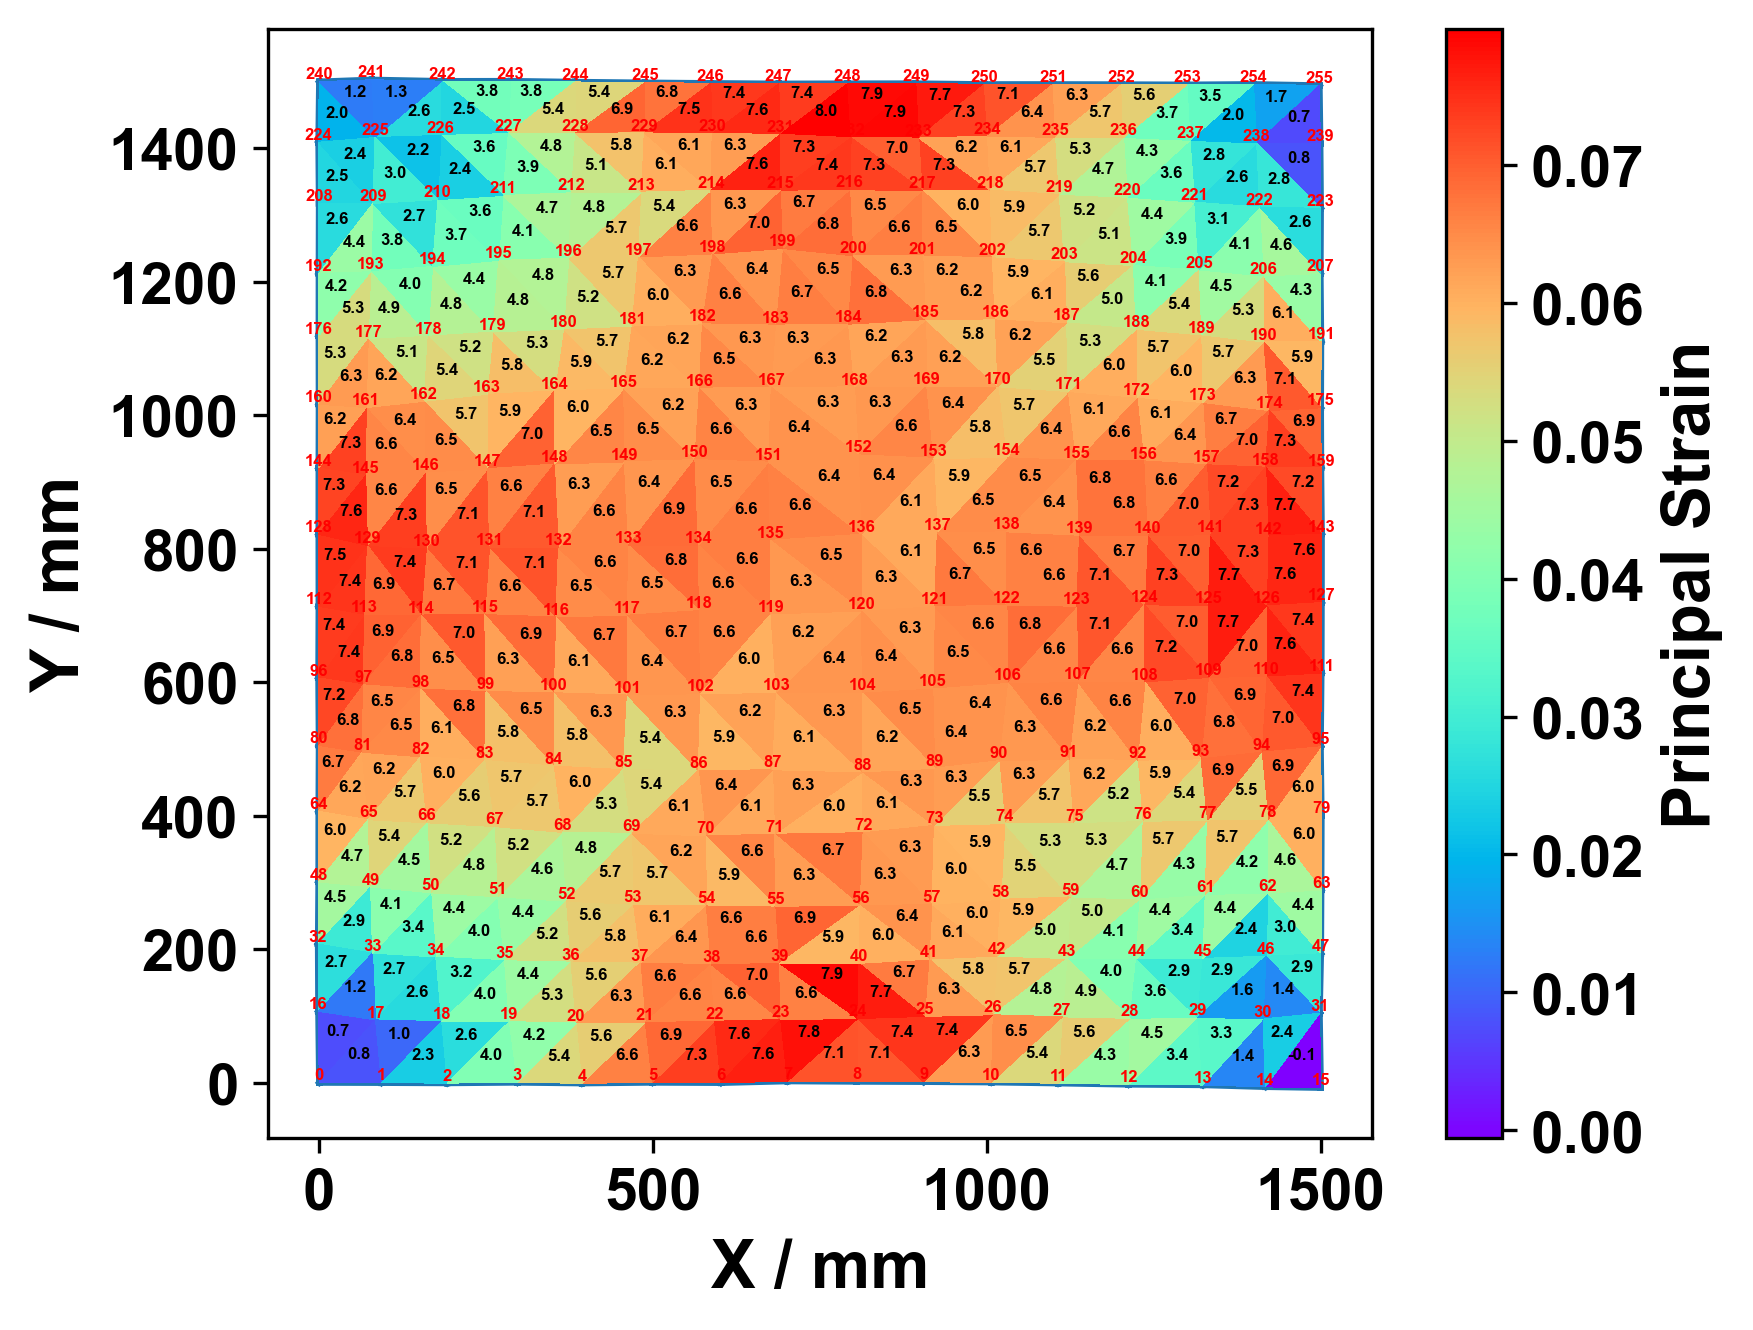

In [7]:
# 6 Visualization of Element Strain Field
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.autoscale()
plt.triplot(triang_deformed) # Plot the 2D triangular results
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

for i in range(xy_deformed.shape[0]):
    plt.text(xy_deformed[i][0], xy_deformed[i][1],
            points_deformed['point_ID'][i],
            fontsize = 4,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

for i in range(len(epsilon1)):
    plt.text((xy_deformed[element_nodes[i][0]][0]+xy_deformed[element_nodes[i][1]][0]+xy_deformed[element_nodes[i][2]][0])/3,
             (xy_deformed[element_nodes[i][0]][1]+xy_deformed[element_nodes[i][1]][1]+xy_deformed[element_nodes[i][2]][1])/3,
            round(epsilon1[i]*100, 1),
            fontsize = 4,
            color = 'k', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

#tpc = plt.tripcolor(triang_deformed, epsilon1, cmap='rainbow', shading='flat')
#plt.colorbar(tpc)

cp = plt.tripcolor(triang_deformed, epsilon1, cmap='rainbow', shading='flat')
plt.colorbar(cp, label="Principal Strain")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18532\4012115209.py:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  P0_ID = np.int0(element_nodes[element_ID][0])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18532\4012115209.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  P1_ID = np.int0(element_nodes[element_ID][1])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18532\4012115209.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  P2_ID = np.int0(element_nodes[element_ID][2])


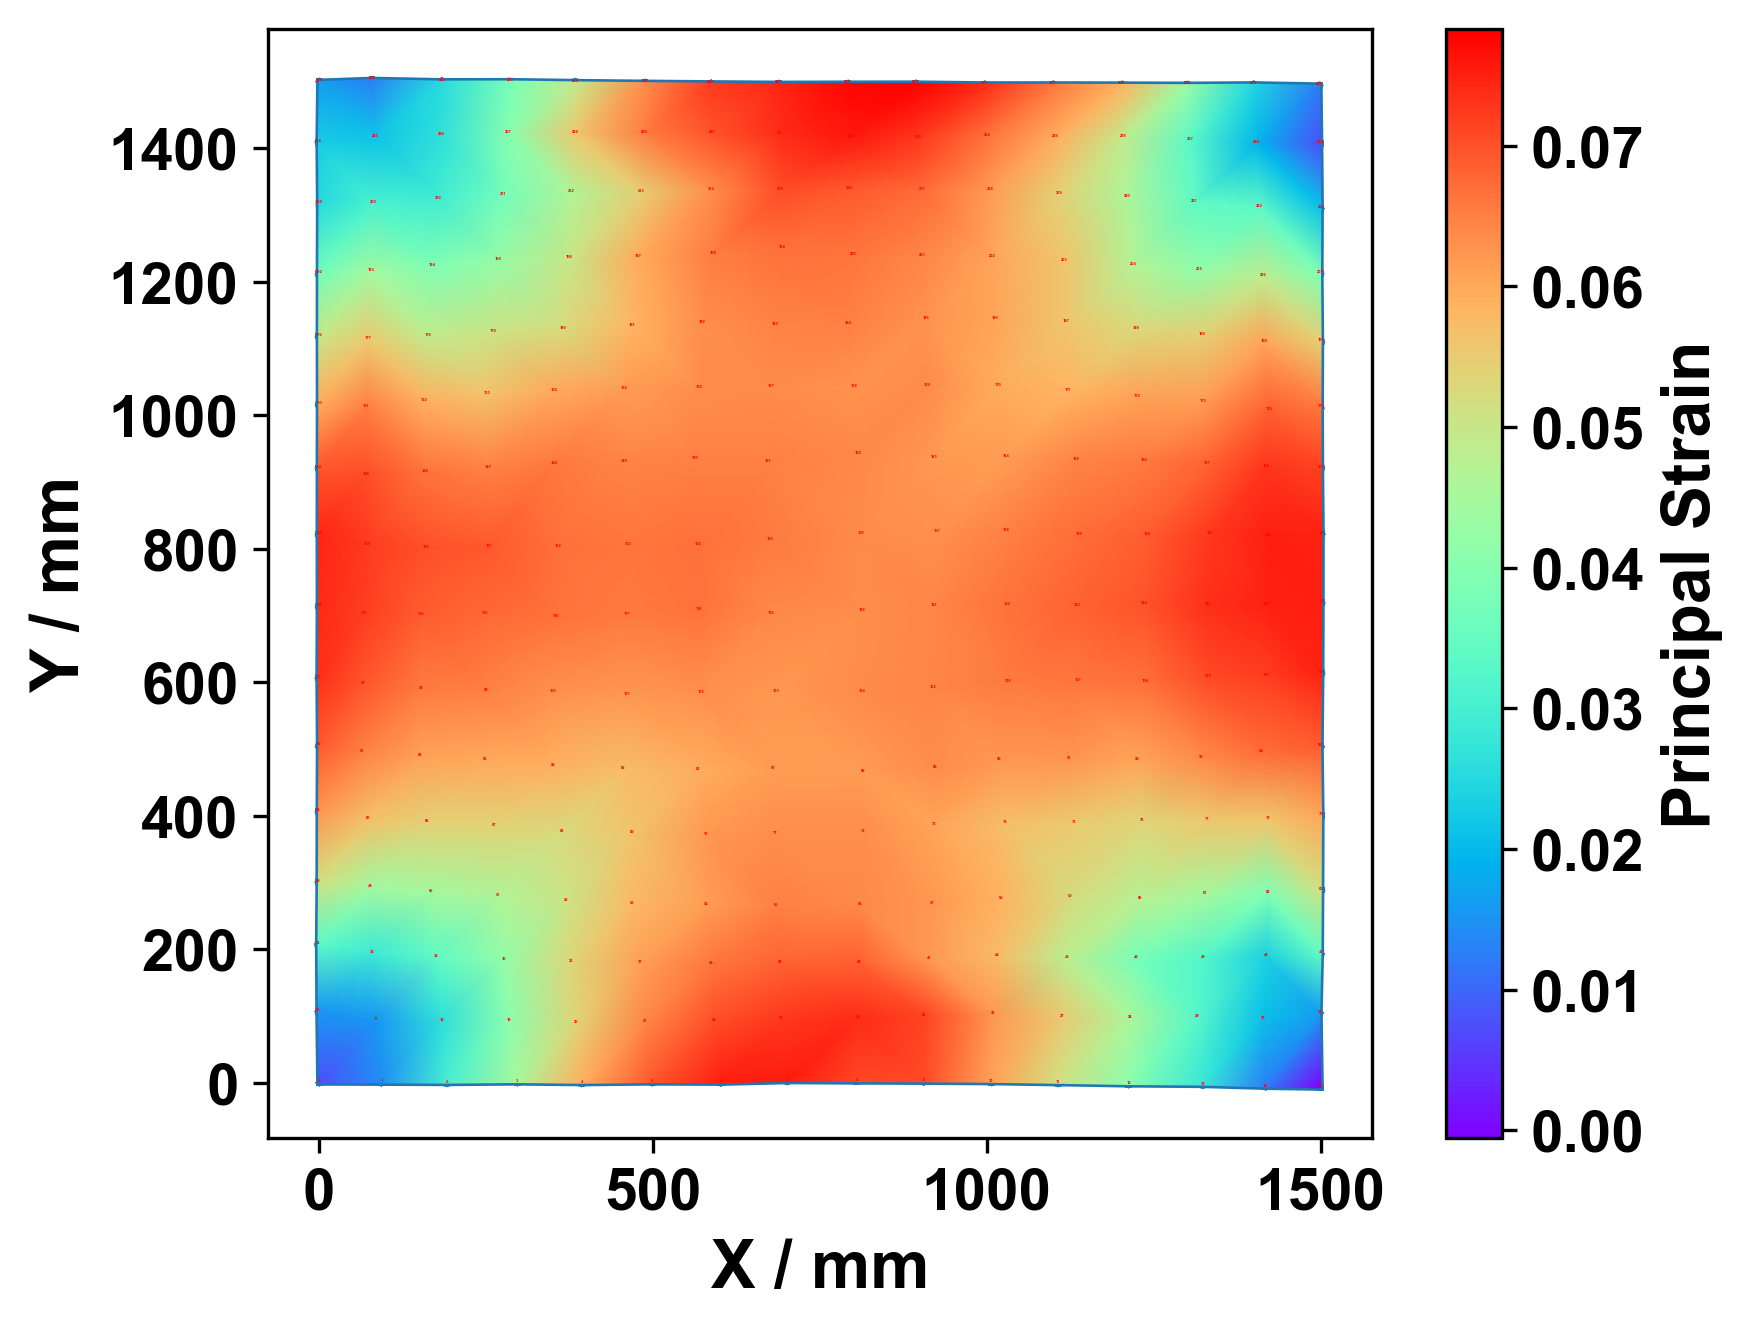

In [8]:
# 7 Calculate the average strain of each point related unit and plot a more uniform strain field (strain smoothing)
def area_calculation(element_ID):
    P0_ID = np.int0(element_nodes[element_ID][0])
    P1_ID = np.int0(element_nodes[element_ID][1])
    P2_ID = np.int0(element_nodes[element_ID][2])
    P0 = np.array(points_deformed.iloc[P0_ID, 1:4])
    P1 = np.array(points_deformed.iloc[P1_ID, 1:4])
    P2 = np.array(points_deformed.iloc[P2_ID, 1:4])
    A = P1 - P0
    B = P2 - P0
    area = np.linalg.norm(np.cross(A, B)) / 2
    return area

def find_sum_area(point_ID):
    sum_area = 0
    for m in range(element_nodes.shape[0]):
        for n in range(element_nodes.shape[1]):
            if point_ID == element_nodes[m][n]:
                sum_area = sum_area + area_calculation(m)
            else:
                pass
    return sum_area

def calculate_weights(point_ID):
    weights = []
    for m in range(element_nodes.shape[0]):
        for n in range(element_nodes.shape[1]):
            if point_ID == element_nodes[m][n]:
                weights.append(area_calculation(m) / find_sum_area(point_ID))
            else:
                pass
    return weights

def find_epsilons1(point_ID):
    epsilons = []
    for m in range(element_nodes.shape[0]):
        for n in range(element_nodes.shape[1]):
            if point_ID == element_nodes[m][n]:
                epsilons.append(epsilon1[m])
            else:
                pass
    return epsilons

def find_epsilons2(point_ID):
    epsilons = []
    for m in range(element_nodes.shape[0]):
        for n in range(element_nodes.shape[1]):
            if point_ID == element_nodes[m][n]:
                epsilons.append(epsilon2[m])
            else:
                pass
    return epsilons

epsilon1_point = [0 for i in range(points_deformed.shape[0])] # Stores the average strain of the cells associated with each node

for i in range(points_deformed.shape[0]):
    point_ID = points_deformed['point_ID'][i]
    values = find_epsilons1(point_ID) # Change the function to transform the maximum/minimum principal strains
    weights = calculate_weights(point_ID)
    epsilon1_point[i] = np.average(values, weights=weights)

# Plot the average strain field stored at the node
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.autoscale()
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
plt.triplot(triang_deformed,)
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

for i in range(xy_deformed.shape[0]):
    plt.text(xy_deformed[i][0], xy_deformed[i][1],
            points_deformed['point_ID'][i],
            fontsize = 0,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

cp = plt.tripcolor(triang_deformed, epsilon1_point, cmap='rainbow', shading='gouraud')
plt.colorbar(cp, label="Principal Strain")

(-76.970695, 1576.9561950000002, -83.15581, 1577.86201)

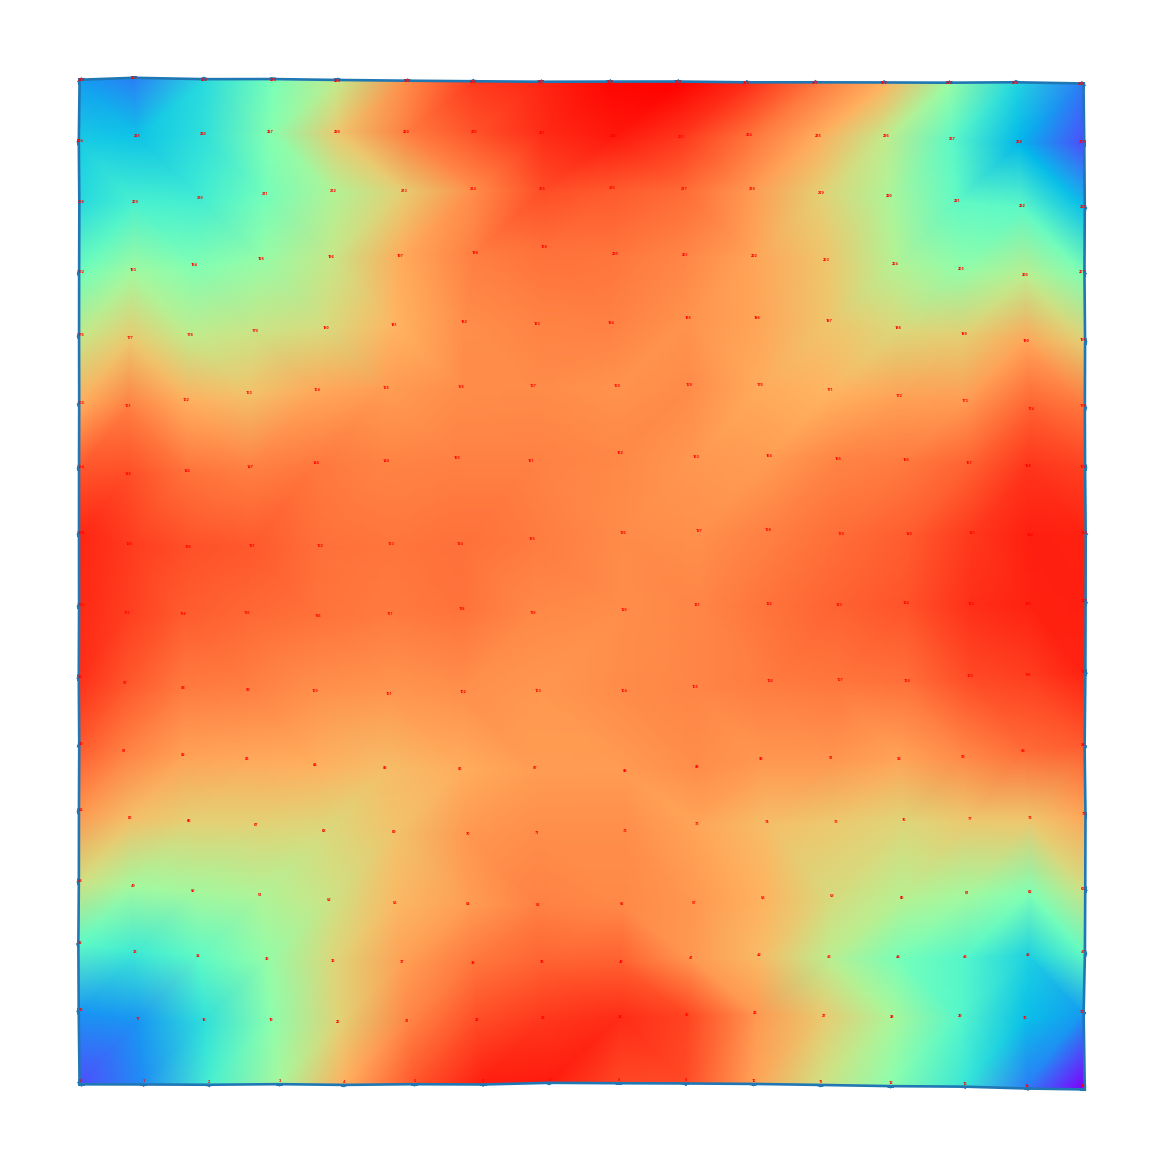

In [9]:
# 8 Plot the average strain field stored on the nodes, deleting the axes with colour bars
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.autoscale()
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
plt.triplot(triang_deformed,)
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')

for i in range(xy_deformed.shape[0]):
    plt.text(xy_deformed[i][0], xy_deformed[i][1],
            points_deformed['point_ID'][i],
            fontsize = 0,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

cp = plt.tripcolor(triang_deformed, epsilon1_point, cmap='rainbow', shading='gouraud')
plt.axis('off')